In [40]:
##Description: This program uses an artificial recurrent neural network called Long Short Term Memory (LSTM) 
#to predict the closing stock price of a corporation (Apple Inc.) using the past 60 day stock price.

import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt


# data visualization

In [41]:
df = pd.read_csv("MSFT.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8590 entries, 0 to 8589
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       8590 non-null   object 
 1   Open       8590 non-null   float64
 2   High       8590 non-null   float64
 3   Low        8590 non-null   float64
 4   Close      8590 non-null   float64
 5   Adj Close  8590 non-null   float64
 6   Volume     8590 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 469.9+ KB


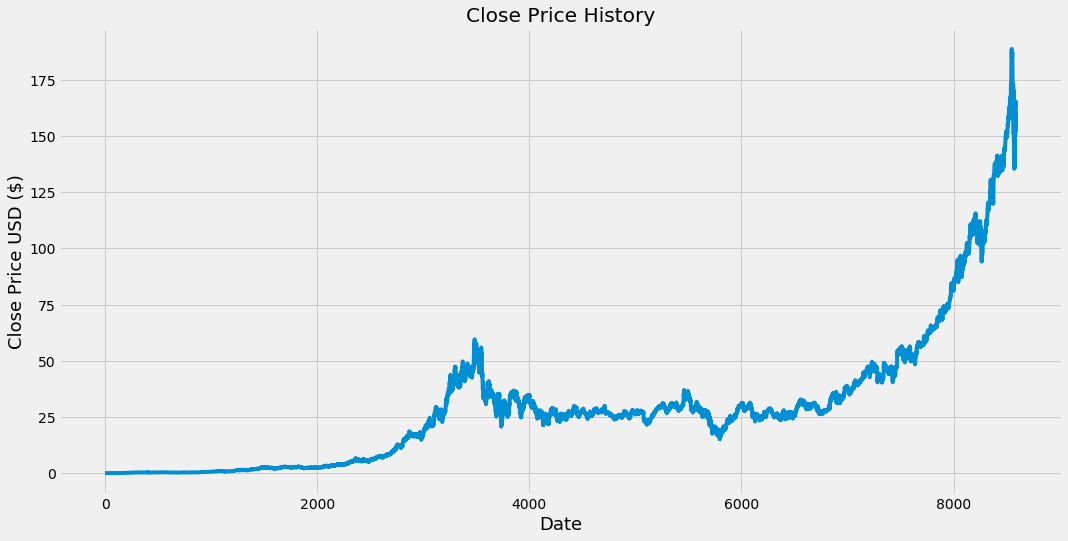

In [42]:
#Visualize the closing price history
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price USD ($)',fontsize=18)
plt.show()

# prepocessing data

In [43]:
#Create a new dataframe with only the 'Close' column
data = df.filter(['Close'])

#Converting the dataframe to a numpy array
dataset = data.values

#Get /Compute the number of rows to train the model on
training_data_len = math.ceil( len(dataset) *.8) 

#Scale the all of the data to be values between 0 and 1 
scaler = MinMaxScaler(feature_range=(0, 1)) 
scaled_data = scaler.fit_transform(dataset)

#Create the scaled training data set 
train_data = scaled_data[0:training_data_len  , : ]
#Split the data into x_train and y_train data sets
#[0,59] -> 60 [1,60]->61
x_train=[]
y_train = []
for i in range(60,len(train_data)):
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])
    
#Convert x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)


# LSTM

In [44]:
#Reshape the data into the shape accepted by the LSTM:3D
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

#Build the LSTM network model
#two LSTM layers with 50 neurons and two Dense layers, one with 25 neurons and the other with 1 neuron.
model = Sequential()
model.add(LSTM(units=50, return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

#Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

#Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)


#Test data set
test_data = scaled_data[training_data_len - 60: , : ]
#Create the x_test and y_test data sets
x_test = []
y_test =  dataset[training_data_len : , : ] #Get all of the rows from index 1603 to the rest and all of the columns (in this case it's only column 'Close'), so 2003 - 1603 = 400 rows of data
for i in range(60,len(test_data)):
    x_test.append(test_data[i-60:i,0])
     
#Convert x_test to a numpy array 
x_test = np.array(x_test)

#Reshape the data into the shape accepted by the LSTM:3D
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))


#Getting the models predicted price values
predictions = model.predict(x_test) 
predictions = scaler.inverse_transform(predictions)#Undo scaling


#Calculate/Get the value of RMSE
rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
rmse



Epoch 1/1
6812/6812 [==============================] - 285s 42ms/step - loss: 7.3316e-05


3.2446457842947343

# result

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


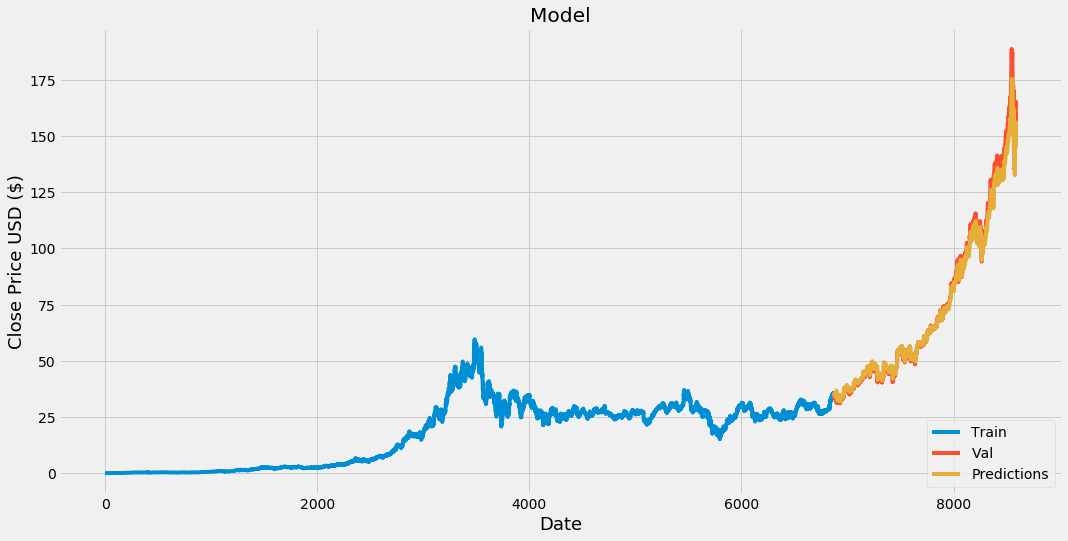

In [45]:
#Plot/Create the data for the graph
#train = data[:training_data_len]
#valid = data[training_data_len:]
train = data.iloc[:training_data_len]
valid = data.iloc[training_data_len:]
valid['Predictions'] = predictions

#Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [46]:
#Show the valid and predicted prices
valid

,Close,Predictions
6872,34.400002,35.576157
6873,35.000000,35.328785
6874,34.980000,35.426296
6875,34.590000,35.564495
6876,33.490002,35.502506
...,...,...
8585,153.830002,146.478073
8586,165.270004,145.178345
8587,163.490005,151.034561
8588,165.130005,154.543106


In [47]:
#predict next day
#Get the quote
msft_quote = pd.read_csv("MSFT.csv")

#Create a new dataframe
new_df = msft_quote.filter(['Close'])

#Get teh last 60 day closing price, Scale the data to be values between 0 and 1
last_60_days = new_df[-60:].values
last_60_days_scaled = scaler.transform(last_60_days)

#create an empty list and append the past 60 day price to it, 
#and then convert it to a numpy array and reshape it so that I can input the data into the model.
X_test = []
X_test.append(last_60_days_scaled)
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


#Get the predicted scaled price
pred_price = model.predict(X_test)

#undo the scaling 
pred_price = scaler.inverse_transform(pred_price)

#next day
print(pred_price)

[[157.28813]]
